# Comparative Analysis of Clustering Techniques for Unsupervised News Categorization

This study leverages headlines and short descriptions from HuffPost articles (2012–2022) to train an unsupervised model for news clustering

---

The dataset was originally compiled from articles published by HuffPost and contains around 210,000 news headlines along with associated metadata. The articles were published between 2012 and 2022, providing a broad representation of news coverage over multiple years. Each record in the dataset corresponds to a distinct news article and is stored in JSON format. The dataset was compiled by Rishabh Misra, who obtained the data through web scraping from the HuffPost website.

---

Source: [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset)
---

Content
Each record in the dataset consists of the following attributes:


*   **category:** category in which the article was published.

*   **headline:** the headline of the news article.

*   **authors:** list of authors who contributed to the article.

*   **link:** link to the original news article.

*   **short_description:** Abstract of the news article.

*   **date:** publication date of the article.








In [2]:
# Import necessary libraries
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from wordcloud import WordCloud
import numpy as np
from collections import Counter
import umap
from IPython.display import display

In [3]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [4]:
# Load the original dataset
file_path = "News_Category_Dataset_v3.json"  # Update with actual path
df = pd.read_json(file_path, lines=True)

# Data Cleaning and Preprocessing
print(f"Number of rows in original dataset: {df.shape[0]}")
print(f"Number of columns in original dataset: {df.shape[1]}")
display(df.head())

df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)
print(f"Null values in each column:\n{df.isnull().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

df = df.dropna(subset=['headline', 'short_description'])
df = df.drop_duplicates()
df = df[df['date'].dt.year.isin(range(2017, 2023))]
print(f"Number of rows after cleaning: {df.shape[0]}")
print(f"Number of columns after cleaning: {df.shape[1]}")

df['text'] = df[['headline', 'short_description']].astype(str).apply(lambda x: ' '.join(x), axis=1)

Number of rows in original dataset: 209527
Number of columns in original dataset: 6


link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

C:\Users\Ella\AppData\Local\Temp\ipykernel_15404\1545133483.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)


Null values in each column:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Number of duplicated rows: 13
Number of rows after cleaning: 47010
Number of columns after cleaning: 6


In [5]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\btrump\b', '', text)  # Remove "trump"
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [6]:
# Tokenize, remove stopwords, and apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [7]:
# TF-IDF Vectorization with bigrams
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2), max_df=0.8, min_df=5)
X = vectorizer.fit_transform(df['filtered_text'])

In [8]:
# Dimensionality Reduction with SVD
svd = TruncatedSVD(n_components=min(X.shape[1], 2500), random_state=42)
X_svd = svd.fit_transform(X).astype(np.float32)

In [9]:
# UMAP for further non-linear reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

c:\Users\Ella\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ella\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
# Normalize data
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X_umap)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

# Function to compute intra-cluster similarity
def intra_cluster_similarity(X, labels):
    unique_clusters = np.unique(labels)
    similarities = []
    for cluster in unique_clusters:
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            sim_matrix = cosine_similarity(cluster_points)
            upper_tri_indices = np.triu_indices_from(sim_matrix, k=1)
            similarities.append(np.mean(sim_matrix[upper_tri_indices]))
    return np.mean(similarities) if similarities else 0

# KMeans clustering
selected_k = [16]
kmeans_models, kmeans_labels, kmeans_metrics = {}, {}, {}

for k in selected_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_normalized)
    df[f'cluster_kmeans_{k}'] = labels
    kmeans_models[k] = kmeans
    kmeans_labels[k] = labels

    # Compute evaluation metrics
    metrics = {
        'silhouette': silhouette_score(X_normalized, labels),
        'davies_bouldin': davies_bouldin_score(X_normalized, labels),
        'calinski_harabasz': calinski_harabasz_score(X_normalized, labels),
        'adjusted_rand': adjusted_rand_score(labels, labels),
        'nmi': normalized_mutual_info_score(labels, labels),
        'similarity': intra_cluster_similarity(X_normalized, labels)
    }

    kmeans_metrics[k] = metrics

    # Assert metric validity
    assert -1 <= metrics['silhouette'] <= 1, "Silhouette score out of range"
    assert metrics['davies_bouldin'] > 0, "Davies-Bouldin score must be positive"
    assert metrics['calinski_harabasz'] > 0, "Calinski-Harabasz score must be positive"
    assert 0 <= metrics['adjusted_rand'] <= 1, "Adjusted Rand Index out of range"
    assert 0 <= metrics['nmi'] <= 1, "NMI score out of range"
    assert 0 <= metrics['similarity'] <= 1, "Similarity score out of range"

# Display metrics
for k, metrics in kmeans_metrics.items():
    print(f"Metrics for k = {k}:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    print("-")

Metrics for k = 16:
silhouette: 0.5336
davies_bouldin: 0.4974
calinski_harabasz: 248220.6489
adjusted_rand: 1.0000
nmi: 1.0000
similarity: 0.9878
-


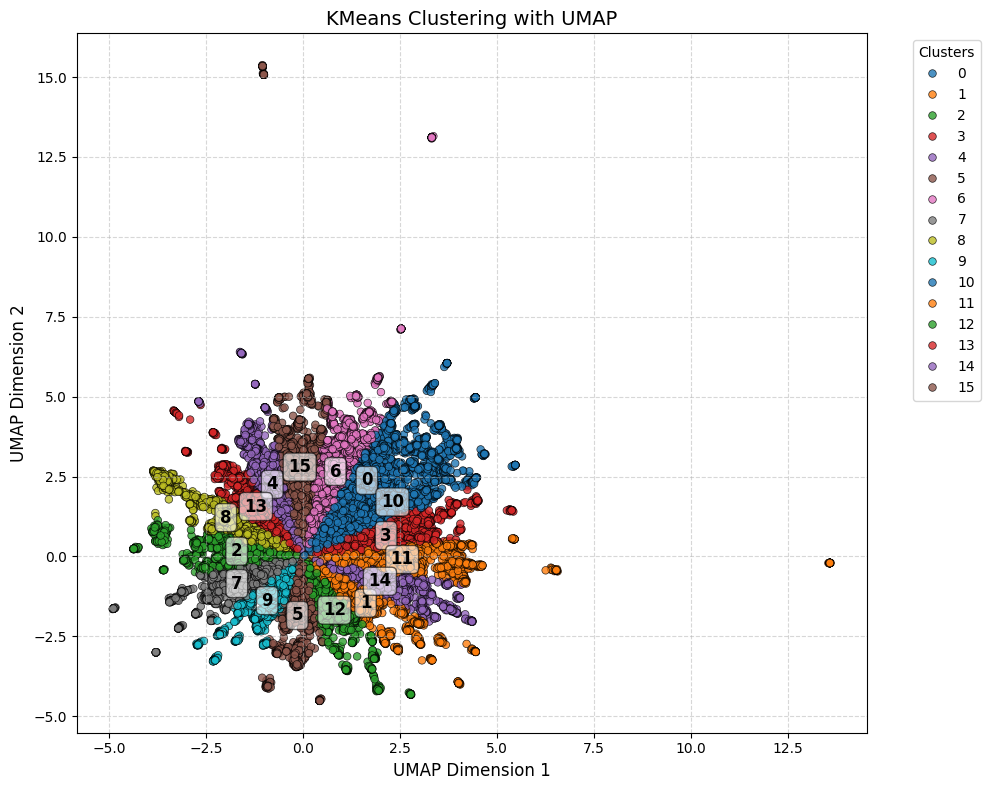

In [13]:
# Add UMAP dimensions to the dataframe
df['X_umap_0'] = X_umap[:, 0]
df['X_umap_1'] = X_umap[:, 1]

plt.figure(figsize=(10, 8))

scatter = sns.scatterplot(
    x=df['X_umap_0'],
    y=df['X_umap_1'],
    hue=df['cluster_kmeans_16'],
    palette='tab10',
    s=30,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8
)

# Compute centroids for each cluster
centroids = df.groupby('cluster_kmeans_16')[['X_umap_0', 'X_umap_1']].mean()

# Add labels at cluster centroids
for cluster, (x, y) in centroids.iterrows():
    plt.text(x, y, str(cluster), fontsize=12, fontweight='bold', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle='round,pad=0.3'))

# Improve labels and layout
plt.title('KMeans Clustering with UMAP', fontsize=14)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

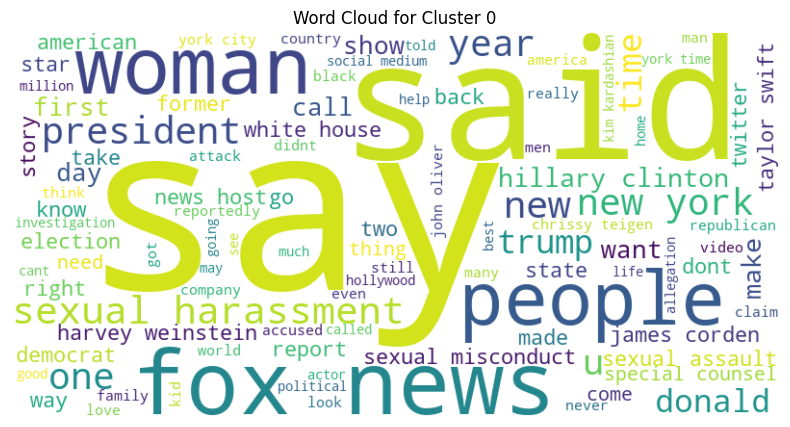

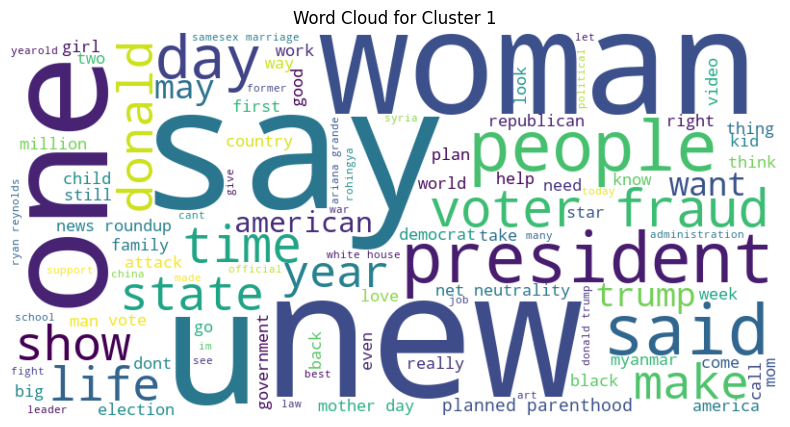

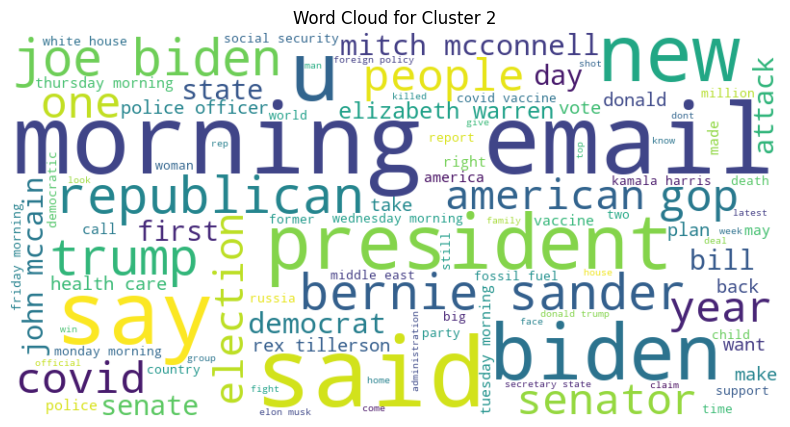

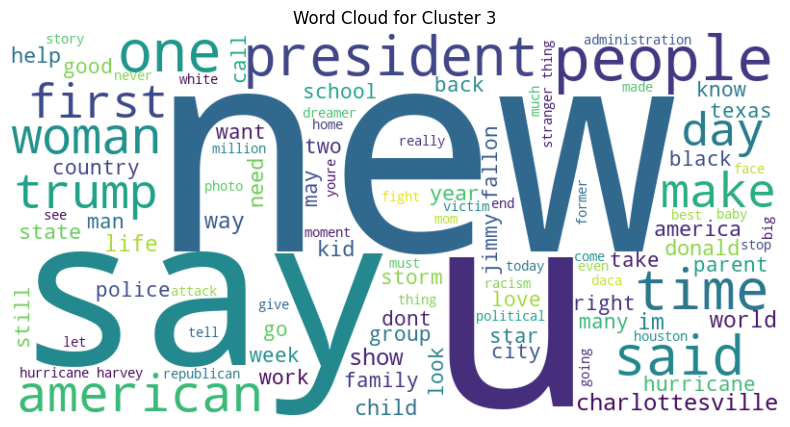

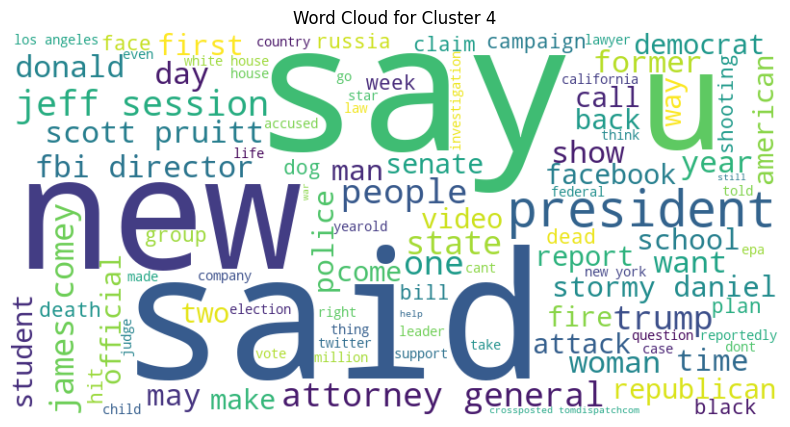

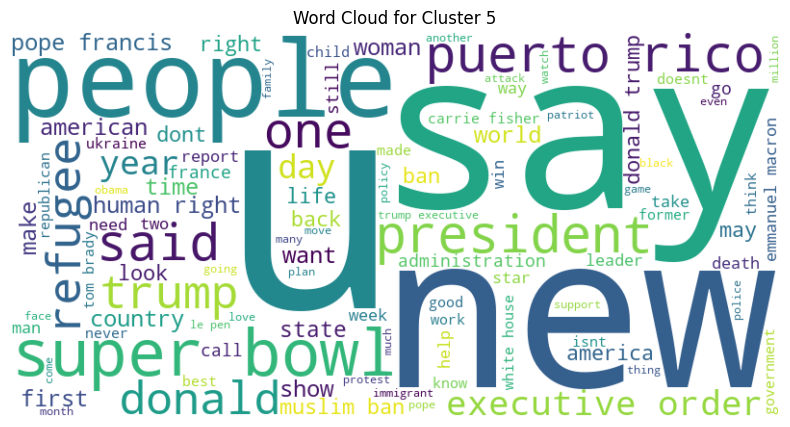

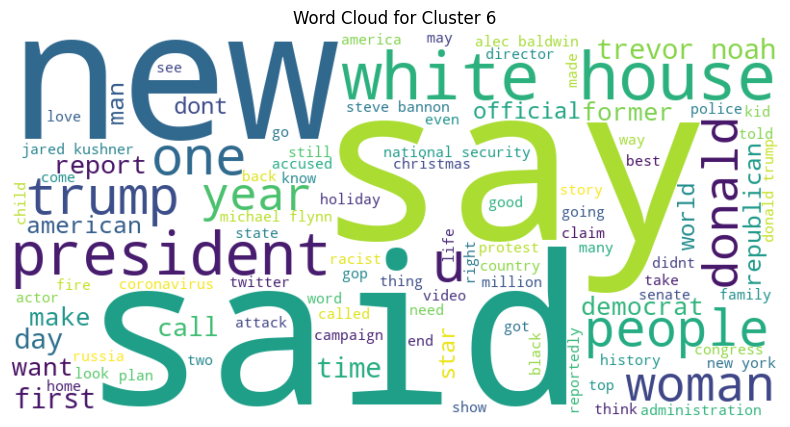

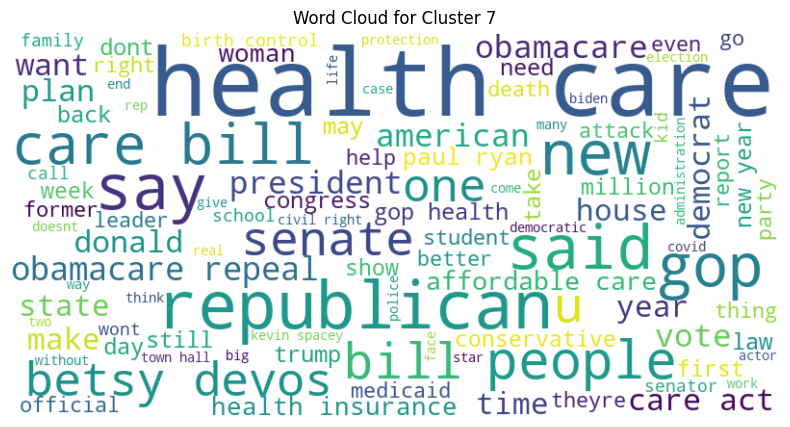

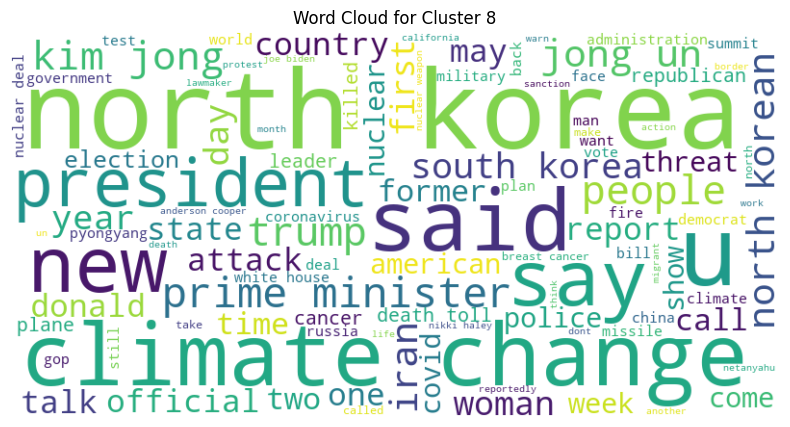

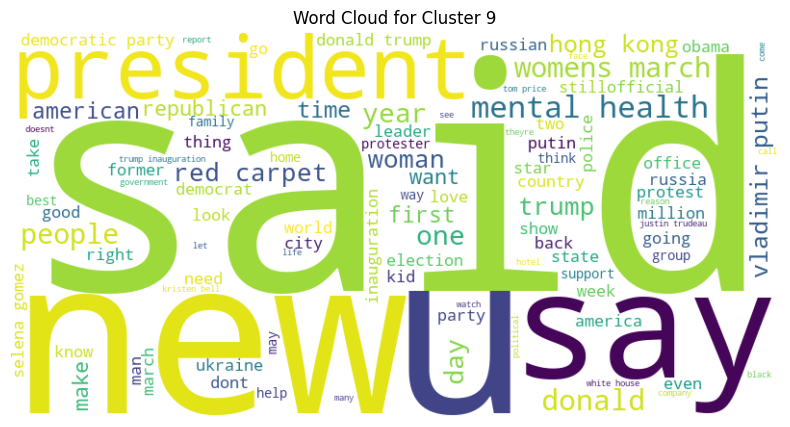

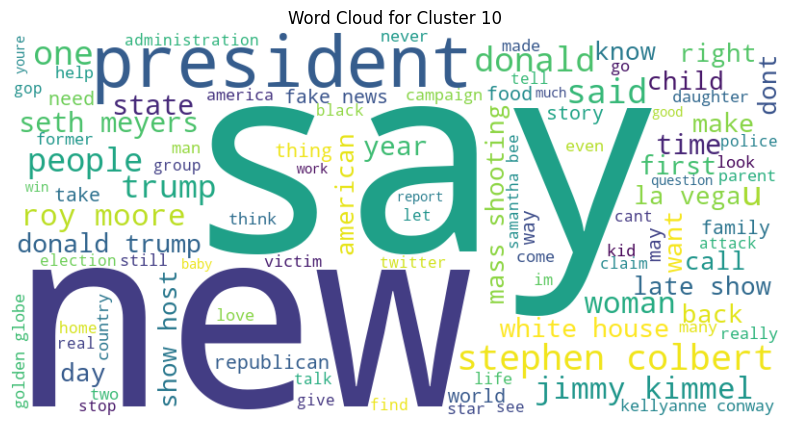

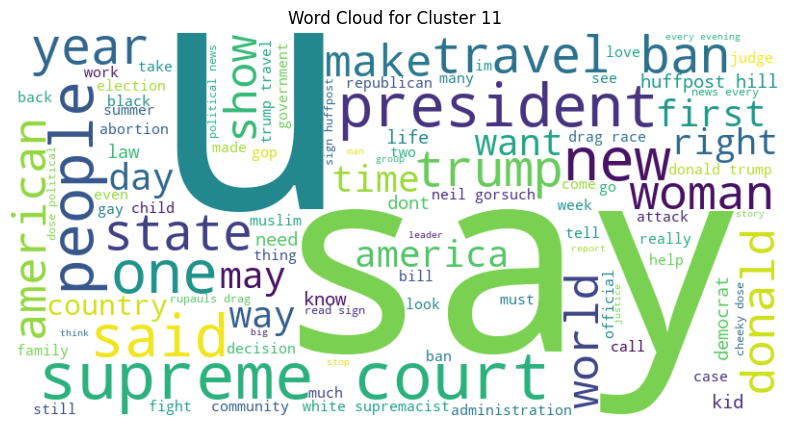

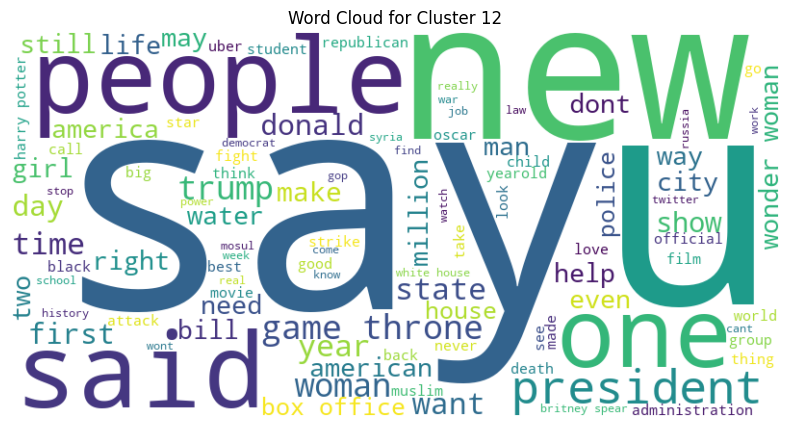

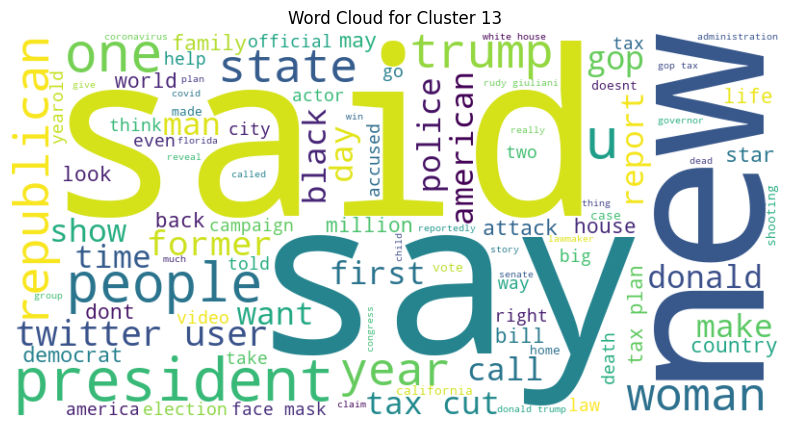

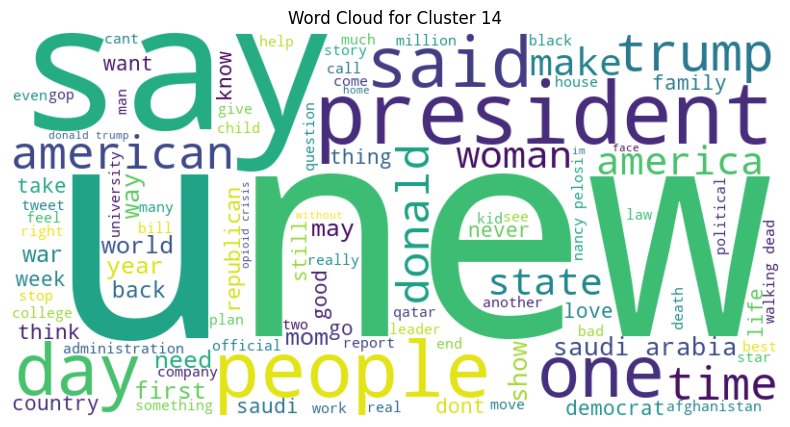

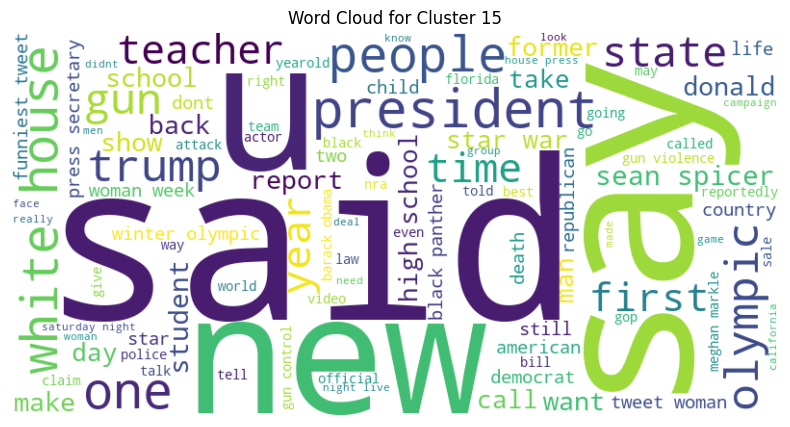

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(cluster_num, df, vectorizer):
  """Generates and displays a word cloud for a specific cluster."""

  # Filter data for the specific cluster
  cluster_data = df[df['cluster_kmeans_16'] == cluster_num]['filtered_text']

  # Join all text from the cluster
  text = ' '.join(cluster_data.astype(str).tolist())

  # Generate word cloud
  wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

  # Display word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"Word Cloud for Cluster {cluster_num}")
  plt.show()


# Loop through each cluster and generate word cloud
for i in range(16):
    generate_wordcloud(i, df, vectorizer)

In [15]:
def cluster_profile(cluster_num, df, vectorizer): # The df and vectorizer are passed as arguments here
    cluster_data = df[df['cluster_kmeans_16'] == cluster_num]
    top_words = [word for word, count in Counter(" ".join(cluster_data['filtered_text']).split()).most_common(10)]
    print(f"Cluster {cluster_num} - Top 10 words: {', '.join(top_words)}")
    print(f"Cluster {cluster_num} - Size: {len(cluster_data)}")
    # Add more profiling metrics as needed (e.g., average headline length, common categories)


# Generate cluster profiles
for i in range(16):
    cluster_profile(i, df, vectorizer) # Make sure 'df' and 'vectorizer' are defined in this scope

Cluster 0 - Top 10 words: new, sexual, say, news, fox, woman, said, president, harassment, time
Cluster 0 - Size: 4236
Cluster 1 - Top 10 words: new, day, say, trump, president, u, woman, one, people, donald
Cluster 1 - Size: 2863
Cluster 2 - Top 10 words: said, email, morning, biden, president, say, trump, u, new, republican
Cluster 2 - Size: 1951
Cluster 3 - Top 10 words: new, people, u, say, white, president, time, one, trump, hurricane
Cluster 3 - Size: 3610
Cluster 4 - Top 10 words: say, said, new, president, session, attorney, people, u, trump, jeff
Cluster 4 - Size: 2832
Cluster 5 - Top 10 words: trump, president, u, donald, refugee, say, new, super, people, bowl
Cluster 5 - Size: 2090
Cluster 6 - Top 10 words: say, house, new, said, white, trump, president, donald, year, people
Cluster 6 - Size: 3960
Cluster 7 - Top 10 words: health, care, gop, republican, bill, obamacare, new, repeal, say, said
Cluster 7 - Size: 1904
Cluster 8 - Top 10 words: north, korea, u, climate, change, 

In [16]:
from collections import Counter

# Function to get word counts for each cluster
def get_word_counts(cluster_num, df):
    cluster_data = df[df['cluster_kmeans_16'] == cluster_num]
    word_counts = Counter(" ".join(cluster_data['filtered_text']).split())
    return word_counts

# Dictionary to hold word counts for each cluster
cluster_word_counts = {}

# Loop through each cluster and get word counts
for i in range(16):
    cluster_word_counts[i] = get_word_counts(i, df)

# Display word counts for each cluster
for cluster_num, word_counts in cluster_word_counts.items():
    print(f"Cluster {cluster_num} - Word Counts:")
    for word, count in word_counts.items():
        print(f"{word}: {count}")
    print("-" * 40)

Cluster 0 - Word Counts:
kim: 75
kardashians: 9
next: 36
boyfriend: 10
could: 105
biochemist: 1
reality: 22
star: 117
told: 67
james: 151
corden: 87
shes: 32
branching: 1
clearly: 15
working: 22
whatever: 3
im: 58
meta: 1
parent: 39
company: 70
instagram: 25
fined: 3
million: 65
irish: 1
regulator: 3
social: 94
medium: 129
giant: 15
violation: 6
data: 12
privacy: 3
law: 48
related: 6
information: 22
child: 58
award: 32
enthusiastic: 2
vmas: 4
guest: 16
go: 111
taylor: 97
swift: 100
singer: 51
channeled: 2
inner: 3
barb: 2
danced: 3
along: 7
lizzo: 1
fangirled: 2
blackpink: 1
arcade: 1
fire: 41
win: 37
butler: 2
accused: 138
sexual: 512
misconduct: 135
several: 21
people: 239
report: 132
pitchfork: 1
consensual: 5
relationship: 21
outside: 15
marriage: 13
disputed: 3
detail: 23
allegation: 165
jared: 12
kushner: 9
blast: 13
nasty: 3
troll: 27
chrissy: 84
teigen: 82
attack: 81
ivanka: 17
who: 17
rei: 2
worker: 21
berkeley: 1
store: 17
vote: 30
unionize: 6
another: 54
labor: 13
follow: 8
